In [ ]:
import keras
from keras.datasets import mnist
import numpy as np
from tensorflow.python.keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from collections import Counter


In [ ]:
# load MNIST dataset from keras
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# normalize data between 0 and 1
train_images=train_images.astype('float32')
test_images=test_images.astype('float32')
train_images = train_images / 255
test_images = test_images / 255
# reshape train data from 3D array (60000, 28, 28) to 2D array (60000,784)
# and test data too
num_pixels = 784
train_images = train_images.reshape(train_images.shape[0], num_pixels)
test_images = test_images.reshape(test_images.shape[0], num_pixels)



In [ ]:
# Function that performs principal component analysis
# The argument x stands for the input data, and d stands for dimension, in which the data is going to be reduced to
# The argument y stands for the input test data, which we should project to the exactly same domain as train data


def PCA(x, y, d):
    x_mean = np.mean(x, axis=0)
    x = x - x_mean
    # compute covariance matrix of x row-wise
    s_x = np.cov(x.T)
    # computing eigenvalues of covariance matrix
    eigvalues, eigvectors = np.linalg.eig(s_x)
    # get the transpose of eigenvectors
    eigvectors = eigvectors.T
    # sort the index counter in descending order
    ix = np.argsort(eigvalues)[::-1]
    eigvalues = eigvalues[ix]
    eigvectors = eigvectors[ix]
    # compute the new matrix w keeping the d most significant values of the eigenvector
    w = eigvectors[0:d]
    # substract mean of training data out of test data
    y = y - x_mean
    # project the eigvector onto the train data space
    pca = np.dot(x, w.T)
    # project the eigvector onto the test data space
    pca_test = np.dot(y, w.T)
    return pca, pca_test


In [ ]:
M_p, M_p_te = PCA(train_images, test_images, 50)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


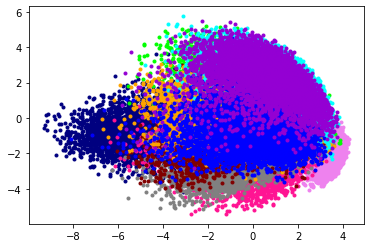

In [ ]:
# B are truth tables in order to find out which rows of the data correspond to which labels (0-9)
B0 = train_labels == 0
B1 = train_labels == 1
B2 = train_labels == 2
B3 = train_labels == 3
B4 = train_labels == 4
B5 = train_labels == 5
B6 = train_labels == 6
B7 = train_labels == 7
B8 = train_labels == 8
B9 = train_labels == 9
# in mp arrays the rows that correspond to each class are stored (e.g. mp0 holds the digit 0, mp1 holds the digit 1
# e.t.c.)
mp0 = M_p[B0 == 1, :]
mp1 = M_p[B1 == 1, :]
mp2 = M_p[B2 == 1, :]
mp3 = M_p[B3 == 1, :]
mp4 = M_p[B4 == 1, :]
mp5 = M_p[B5 == 1, :]
mp6 = M_p[B6 == 1, :]
mp7 = M_p[B7 == 1, :]
mp8 = M_p[B8 == 1, :]
mp9 = M_p[B9 == 1, :]

# plotting the pca results for dimensionality reduction (for d=2)
plt.scatter(mp0[:, 0], mp0[:, 1], c="navy", marker=".")
plt.scatter(mp1[:, 0], mp1[:, 1], c="violet",  marker=".")
plt.scatter(mp2[:, 0], mp2[:, 1], c="deeppink",  marker=".")
plt.scatter(mp3[:, 0], mp3[:, 1], c="grey",  marker=".")
plt.scatter(mp4[:, 0], mp4[:, 1], c="lime",  marker=".")
plt.scatter(mp5[:, 0], mp5[:, 1], c="maroon",  marker=".")
plt.scatter(mp6[:, 0], mp6[:, 1], c="orange",  marker=".")
plt.scatter(mp7[:, 0], mp7[:, 1], c="aqua",  marker=".")
plt.scatter(mp8[:, 0], mp8[:, 1], c="blue",  marker=".")
plt.scatter(mp9[:, 0], mp9[:, 1], c="darkviolet",  marker=".")

plt.show()

In [ ]:
# take the first 3000 rows from train and 500 from test to classify (because original data is too big)
M_p_s = M_p[:3000, :]
M_p_te_s = M_p_te[:500, :]
train_labels_s = train_labels[:3000]
test_labels_s = test_labels[:500]

In [ ]:
# function that caculates the euclidean distance
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))


In [ ]:
# the k-nearest neighbor class
class KNN:

    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_idx = np.argsort(distances)[:self.k]
        # Get the labels of the k nearest neighbor training samples
        k_neighbor_labels = [self.y_train[i] for i in k_idx]
        # return the most common class label
        most_common = Counter(k_neighbor_labels).most_common(1)
        return most_common[0][0]



In [ ]:
# the nearest centroid class
class NearestCentroid:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.num_images = len(images)

    def fit(self):
        classes = np.unique(self.labels)
        self.classes = classes

        centroids = np.empty((classes.shape[0], self.images.shape[1]))
        # master list
        label_to_image = []                                     

        for cl in classes:
            # create a list for each class 
            img_label = []                                      
            for j in range(0, self.num_images):
                # if the label equals the picture label
                if self.labels[j] == cl: 
                    # append to list                      
                    img_label.append(self.images[j])
            # append to master list                   
            label_to_image.append(img_label)                    
        # calculate the mean for centroids
        for i in range(0, len(classes)):  
            centroids[i] = np.mean(label_to_image[i], axis=0)
        self.centroids = centroids

    def predict(self, images):
        classified = []
        for image in images:
            smallest_dist = 99999999
            cl = None
            for i, centroid in enumerate(self.centroids):
               # calculate the distance of the picture to each centroid
                dist = np.sqrt(np.sum((image - centroid) ** 2)) 
                if dist < smallest_dist:
                    smallest_dist = dist
                    cl = i
            # append classified picture
            classified.append([cl])                                 

        return classified



In [ ]:
# fucntion that calculates accuracy
def accuracy(y_true, y_pred):
    acc = np.sum(y_true == y_pred) / len(y_true)
    return acc

In [ ]:
# the main class
if __name__=="__main__":
  k = 3  # set k to 1 or 3
  clf = KNN(k=k)  # call KNN class
  # fit the training images and labels
  clf.fit(M_p_s, train_labels_s)
  # predict results with test images
  predictions = clf.predict(M_p_te_s)
  print("Predictions of k-nn: ", predictions)
  # find the accuracy using predicitions and test labels at a scale of 100
  print("k-NN classification accuracy: ", format(accuracy(test_labels_s, predictions) * 100, ".2f"), "%")


  clf1 = NearestCentroid(M_p_s,train_labels_s) # call nearest centroid class
   # fit the training images and labels
  clf1.fit()
  # predict results with test images
  predictions2 = clf1.predict(M_p_te_s)
  
  predictions2 = np.array(predictions2)
  predictions2 = predictions2.flatten()
  print("Predictions of nearest centroid: ", predictions2)
  # find the accuracy using predicitions and test labels at a scale of 100
  print("Nearest Centroid classification accuracy: ", format(accuracy(test_labels_s, predictions2)*100, ".2f"), "%")


Predictions of k-nn:  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 5 5 5 1 8 4 4 6 3 5 5 6 0 4 1 9 5 7 2 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 3 9 7 9 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1 9 4 8
 7 3 9 7 9 4 4 9 2 5 4 7 6 7 9 0 5 8 5 6 6 5 7 8 1 0 1 6 4 6 7 3 1 7 1 8 2
 0 2 9 9 5 5 1 5 6 0 3 4 4 6 5 4 6 5 4 5 1 4 4 7 2 3 2 1 1 8 1 8 1 8 5 0 8
 9 2 5 0 1 1 1 0 4 0 3 1 6 4 2 3 6 1 1 1 3 9 5 2 9 4 5 9 3 9 0 3 5 5 5 7 2
 2 7 1 2 8 4 1 7 3 3 8 7 7 9 2 2 4 1 5 8 9 7 2 2 0 6 4 2 9 1 9 5 7 7 2 6 2
 6 8 5 7 7 9 1 0 1 8 0 3 0 1 9 9 4 1 8 2 1 2 9 7 5 9 2 6 4 1 5 8 2 9 2 0 4
 0 0 2 8 1 7 1 2 4 0 2 7 4 3 3 0 0 5 1 9 6 5 2 5 7 7 9 3 0 4 6 0 7 1 1 2 1
 5 3 3 9 7 8 6 5 4 1 3 8 1 0 5 1 9 1 5 5 6 1 8 5 1 4 9 4 6 2 2 5 0 6 5 6 3
 7 2 0 8 8 5 4 1 1 4 0 7 3 7 6 1 6 2 1 9 2 8 6 1 9 5 2 5 4 4 2 8 3 5 2 4 5
 0 3 1 7 7 5 7 9 7 1 9 2 1 4 2 9 2 0 4 9 1 4 8 1 8 4 5 9 7 8 3 7 6 0 0 3 0
 2 0 6 4 9 3 3 3 2 3 9 1 2 6 8 0 9 6 6 6 7 8 8 2 7 5 8 9 6 1 8 4 1 2 6 8 1
 9 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
